In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os, zipfile

zip_path = "/content/drive/MyDrive/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0.zip"

# 2. Extract to a clean folder
extract_path = "/content/gesture_extracted"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("Extraction complete!")
print("Extracted to:", extract_path)
print("Top-level contents:", os.listdir(extract_path))

# 3. Set DATA_ROOT manually based on the known folder structure
DATA_ROOT = "/content/gesture_extracted/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0"

print("\n DATA_ROOT set to:", DATA_ROOT)
print("DATA_ROOT contents:", os.listdir(DATA_ROOT))


Extraction complete!
Extracted to: /content/gesture_extracted
Top-level contents: ['gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0']

 DATA_ROOT set to: /content/gesture_extracted/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0
DATA_ROOT contents: ['grabmyo_convert_wfdb_to_mat.py', 'MotionSequence.txt', 'DeviceInfo.pdf', 'grabmyo_feature_extraction.m', 'Electrodelocation.pdf', 'Session3', 'featiDFTl.m', 'RECORDS', 'LICENSE.txt', 'Session2', 'subject-info.csv', 'readme.txt', 'segmentEMG.m', 'GestureList.JPG', 'Session1', 'grabmyo_visualize.py', 'SHA256SUMS.txt']


In [2]:
 # =========================
# 0) Install + Imports
# =========================
!pip -q install wfdb scikit-learn scipy pandas

import os, re, glob
import numpy as np
import pandas as pd
import wfdb
from numpy.linalg import lstsq

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

# =========================
# 1) Find DATA_ROOT under /content
# =========================

base = "/content"
candidates = glob.glob(os.path.join(base, "gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0*"))

DATA_ROOT = None
for c in candidates:
    if not os.path.isdir(c):
        continue
    subdirs = os.listdir(c)
    # Case 1: Sessions directly here
    if all(s in subdirs for s in ["Session1", "Session2", "Session3"]):
        DATA_ROOT = c
        break
    # Case 2: Sessions one level deeper
    for d in subdirs:
        inner = os.path.join(c, d)
        if os.path.isdir(inner):
            inner_subdirs = os.listdir(inner)
            if all(s in inner_subdirs for s in ["Session1", "Session2", "Session3"]):
                DATA_ROOT = inner
                break
    if DATA_ROOT is not None:
        break

if DATA_ROOT is None:
    raise RuntimeError("Could not find GrabMyo dataset under /content. Make sure you ran the unzip cell.")

print("Using DATA_ROOT:", DATA_ROOT)
print("DATA_ROOT contents:", os.listdir(DATA_ROOT))

# =========================
# 2) Config (session/gesture/channels)
# =========================

SESSIONS = ["Session1", "Session2", "Session3"]
TARGET_GESTURE = 1           # you can change to 10 later
FIXED_SECONDS = 4            # enforce 4-second trials
MAX_SUBJECT = 43             # include up to subject 43 (imposters 39–43)

# EMG channels of interest (1-based indices from header)
CHANNELS_1B = [9,10,11,12,13,14,15,16,18,19,20,21,22,23]
CHANNELS = [c - 1 for c in CHANNELS_1B]   # convert to 0-based

print("Sessions:", SESSIONS)
print("Gesture:", TARGET_GESTURE)
print("Channels (1-based):", CHANNELS_1B)

# =========================
# 3) Feature helpers
# =========================

def feat_rms(x):
    return np.sqrt(np.mean(x**2))

def feat_mav(x):
    return np.mean(np.abs(x))

def feat_wl(x):
    return np.sum(np.abs(np.diff(x)))

def feat_zc(x, thr=1e-3):
    x1, x2 = x[:-1], x[1:]
    return np.sum(((x1 * x2) < 0) & (np.abs(x1 - x2) > thr))

def feat_ssc(x, thr=1e-3):
    x0, x1, x2 = x[:-2], x[1:-1], x[2:]
    return np.sum(((x1 - x0) * (x1 - x2) > 0) &
                  ((np.abs(x1 - x0) > thr) | (np.abs(x1 - x2) > thr)))

def feat_ar(x, order=4):
    x = x - np.mean(x)
    if len(x) <= order:
        return np.zeros(order, dtype=np.float32)
    X = np.column_stack([x[order-k-1:-k-1] for k in range(order)])
    y = x[order:]
    a, *_ = lstsq(X, y, rcond=None)
    return a.astype(np.float32)

def per_channel_features(sig_1d):
    """
    sig_1d: (samples,) for one channel
    returns 9 features: RMS, MAV, WL, ZC, SSC, AR1..AR4
    """
    return np.concatenate((
        [feat_rms(sig_1d), feat_mav(sig_1d), feat_wl(sig_1d),
         feat_zc(sig_1d), feat_ssc(sig_1d)],
        feat_ar(sig_1d, order=4)
    ), axis=0)

def zscore_channels(arr, eps=1e-8):
    """
    Per-trial z-score per channel
    arr: (samples, channels)
    """
    mu = arr.mean(axis=0, keepdims=True)
    sd = arr.std(axis=0, ddof=0, keepdims=True)
    return (arr - mu) / (sd + eps)

# =========================
# 4) Gather trials (gesture, subjects 1..43, sessions 1–3)
# =========================

records = []   # list of (session_name, sess_idx, subject, trial_id, path_no_ext)

for session in SESSIONS:
    session_dir = os.path.join(DATA_ROOT, session)
    all_pdirs = sorted(
        d for d in os.listdir(session_dir)
        if d.startswith(session.lower() + "_participant")
    )

    for d in all_pdirs:
        m = re.search(r"participant(\d+)", d)
        if not m:
            continue
        pid = int(m.group(1))
        if pid > MAX_SUBJECT:
            continue

        ppath = os.path.join(session_dir, d)
        pattern = re.compile(
            rf"{session.lower()}_participant{pid}_gesture{TARGET_GESTURE}_trial(\d+)\.hea$"
        )

        for hf in sorted(glob.glob(os.path.join(ppath, f"*gesture{TARGET_GESTURE}_trial*.hea"))):
            base = os.path.basename(hf)
            mm = pattern.search(base)
            if not mm:
                continue
            trial_id = int(mm.group(1))
            path_no_ext = hf[:-4]
            if os.path.exists(path_no_ext + ".dat"):
                if session.endswith("1"):
                    sess_idx = 1
                elif session.endswith("2"):
                    sess_idx = 2
                elif session.endswith("3"):
                    sess_idx = 3
                else:
                    sess_idx = None
                records.append((session, sess_idx, pid, trial_id, path_no_ext))

print(f"\nTotal trials loaded (gesture {TARGET_GESTURE}, subjects 1..{MAX_SUBJECT}): {len(records)}")
print("Example record:", records[0])

# =========================
# 5) Extract features for all trials (one time)
# =========================

X = []
subjects = []
sessions_idx = []

for session_name, sess_idx, pid, trial_id, rec in records:
    sig, meta = wfdb.rdsamp(rec)
    fs = int(round(meta['fs']))

    # keep only your selected channels
    sig = sig[:, CHANNELS]
    sig = zscore_channels(sig)

    # enforce fixed duration
    target_len = FIXED_SECONDS * fs
    if sig.shape[0] < target_len:
        pad = np.zeros((target_len - sig.shape[0], sig.shape[1]), dtype=sig.dtype)
        sig = np.vstack([sig, pad])
    elif sig.shape[0] > target_len:
        sig = sig[:target_len, :]

    # per-channel features then concat
    feats = np.concatenate(
        [per_channel_features(sig[:, ch]) for ch in range(sig.shape[1])],
        axis=0
    )
    X.append(feats)
    subjects.append(pid)
    sessions_idx.append(sess_idx)

X = np.vstack(X)
subjects = np.array(subjects, dtype=int)
sessions_idx = np.array(sessions_idx, dtype=int)

print("\nFeature matrix shape:", X.shape)
print("Unique subjects:", np.unique(subjects))
print("Unique sessions:", np.unique(sessions_idx))

# Build metadata once
metadata = pd.DataFrame({
    "subject": subjects,
    "session": sessions_idx,
})

# =========================
# 6) Helper to run pipeline for a given MAIN_SUBJECT
# =========================

def run_for_subject(MAIN_SUBJECT):
    print("\n" + "="*60)
    print(f" Running authentication experiment for subject {MAIN_SUBJECT}")
    print("="*60)

    # labels: 1 for MAIN_SUBJECT, 0 for all others
    y = (metadata["subject"] == MAIN_SUBJECT).astype(int).values
    class_counts = dict(zip(*np.unique(y, return_counts=True)))
    print("Class counts (0=others, 1=MAIN_SUBJECT):", class_counts)

    # train/test masks (same logic as before)
    train_mask = (
        (metadata['subject'] <= 35) |  # All subjects 1–35, any session
        ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'].isin([1, 2])))
    )
    test_mask = (
        ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'] == 3)) |
        (metadata['subject'] >= 39)
    )

    X_train = X[train_mask.values]
    y_train = y[train_mask.values]
    X_test  = X[test_mask.values]
    y_test  = y[test_mask.values]

    print("Train samples:", X_train.shape[0])
    print("Test samples :", X_test.shape[0])
    print("Train class counts:", dict(zip(*np.unique(y_train, return_counts=True))))
    print("Test  class counts:", dict(zip(*np.unique(y_test,  return_counts=True))))

    # Train RF
    rf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Default threshold 0.5
    y_prob = rf.predict_proba(X_test)[:, 1]
    y_pred_05 = (y_prob >= 0.5).astype(int)
    tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_05).ravel()

    FAR1  = fp1 / (fp1 + tn1) * 100 if (fp1 + tn1) else 0
    FRR1  = fn1 / (fn1 + tp1) * 100 if (fn1 + tp1) else 0
    PREC1 = precision_score(y_test, y_pred_05, zero_division=0) * 100
    REC1  = recall_score(y_test, y_pred_05, zero_division=0) * 100
    SPEC1 = tn1 / (tn1 + fp1) * 100 if (tn1 + fp1) else 0
    F11   = f1_score(y_test, y_pred_05, zero_division=0) * 100
    ACC1  = accuracy_score(y_test, y_pred_05) * 100
    AUC1  = roc_auc_score(y_test, y_prob)

    print("\n--- RESULTS: Threshold = 0.5 ---")
    print("TP:", tp1, "TN:", tn1, "FP:", fp1, "FN:", fn1)
    print(f"FAR %        : {FAR1:.2f}")
    print(f"FRR %        : {FRR1:.2f}")
    print(f"PRECISION %  : {PREC1:.2f}")
    print(f"RECALL %     : {REC1:.2f}")
    print(f"Specificity %: {SPEC1:.2f}")
    print(f"F1 %         : {F11:.2f}")
    print(f"ACCURACY %   : {ACC1:.2f}")
    print(f"ROC AUC      : {AUC1:.3f}")
    print("\nClassification report (0.5):")
    print(classification_report(y_test, y_pred_05, digits=3, zero_division=0))

    # Threshold tuning (FAR = 0, maximize F1)
    best_thresh = 0.5
    best_f1 = -1
    best_stats = None

    thresholds = np.linspace(0.0, 1.0, 101)
    for t in thresholds:
        pred_t = (y_prob >= t).astype(int)
        tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, pred_t).ravel()
        if fp_t != 0:   # enforce FAR = 0
            continue
        denom = (2 * tp_t + fp_t + fn_t)
        f1_t = (2 * tp_t / denom) if denom > 0 else 0.0
        if f1_t > best_f1:
            best_f1 = f1_t
            best_thresh = t
            best_stats = (tn_t, fp_t, fn_t, tp_t)

    if best_stats is None:
        print("\n No threshold found with FAR = 0. Using 0.5 only.")
        return

    tn2, fp2, fn2, tp2 = best_stats
    FAR2  = fp2 / (fp2 + tn2) * 100 if (fp2 + tn2) else 0.0
    FRR2  = fn2 / (fn2 + tp2) * 100 if (fn2 + tp2) else 0.0
    PREC2 = (tp2 / (tp2 + fp2) * 100) if (tp2 + fp2) else 0.0
    REC2  = (tp2 / (tp2 + fn2) * 100) if (tp2 + fn2) else 0.0
    SPEC2 = tn2 / (tn2 + fp2) * 100 if (tn2 + fp2) else 0.0
    F12   = (2 * tp2 / (2 * tp2 + fp2 + fn2) * 100) if (2 * tp2 + fp2 + fn2) else 0.0
    ACC2  = (tn2 + tp2) / (tn2 + tp2 + fn2 + fp2) * 100

    print(f"\n Best threshold with FAR = 0: {best_thresh:.3f}")
    print(f"Best F1 (FAR = 0): {best_f1:.3f}")

    print("\n--- RESULTS: Optimal threshold (FAR = 0) ---")
    print("TP:", tp2, "TN:", tn2, "FP:", fp2, "FN:", fn2)
    print(f"FAR %        : {FAR2:.2f}")
    print(f"FRR %        : {FRR2:.2f}")
    print(f"PRECISION %  : {PREC2:.2f}")
    print(f"RECALL %     : {REC2:.2f}")
    print(f"Specificity %: {SPEC2:.2f}")
    print(f"F1 %         : {F12:.2f}")
    print(f"ACCURACY %   : {ACC2:.2f}")
    print(f"ROC AUC      : {AUC1:.3f}")  # AUC based on probabilities, same as before

    print("\nClassification report (optimal threshold):")
    y_pred_opt = (y_prob >= best_thresh).astype(int)
    print(classification_report(y_test, y_pred_opt, digits=3, zero_division=0))

# =========================
# 7) Run for subjects 36, 37, 38
# =========================

for subj in [36, 37, 38, 39]:
    run_for_subject(subj)


Using DATA_ROOT: /content/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0
DATA_ROOT contents: ['grabmyo_convert_wfdb_to_mat.py', 'MotionSequence.txt', 'DeviceInfo.pdf', 'grabmyo_feature_extraction.m', 'Electrodelocation.pdf', 'Session3', 'featiDFTl.m', 'RECORDS', 'LICENSE.txt', 'Session2', 'subject-info.csv', 'readme.txt', 'segmentEMG.m', 'GestureList.JPG', 'Session1', 'grabmyo_visualize.py', 'SHA256SUMS.txt']
Sessions: ['Session1', 'Session2', 'Session3']
Gesture: 1
Channels (1-based): [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23]

Total trials loaded (gesture 1, subjects 1..43): 903
Example record: ('Session1', 1, 1, 1, '/content/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0/Session1/session1_participant1/session1_participant1_gesture1_trial1')

Feature matrix shape: (903, 126)
Unique subjects: [ 1  2  3  4  5  6  

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

results_opt = []   # will store optimal-threshold metrics per subject
results_05  = []   # (optional) default-threshold metrics per subject

def run_for_subject(MAIN_SUBJECT):
    print("\n" + "="*60)
    print(f"Running authentication experiment for subject {MAIN_SUBJECT}")
    print("="*60)

    # labels: 1 for MAIN_SUBJECT, 0 for all others
    y = (metadata["subject"] == MAIN_SUBJECT).astype(int).values
    class_counts = dict(zip(*np.unique(y, return_counts=True)))
    print("Class counts (0=others, 1=MAIN_SUBJECT):", class_counts)

    # train/test masks (same logic as before)
    train_mask = (
        (metadata['subject'] <= 35) |
        ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'].isin([1, 2])))
    )
    test_mask = (
        ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'] == 3)) |
        (metadata['subject'] >= 39)
    )

    X_train = X[train_mask.values]
    y_train = y[train_mask.values]
    X_test  = X[test_mask.values]
    y_test  = y[test_mask.values]

    print("Train samples:", X_train.shape[0])
    print("Test samples :", X_test.shape[0])
    print("Train class counts:", dict(zip(*np.unique(y_train, return_counts=True))))
    print("Test  class counts:", dict(zip(*np.unique(y_test,  return_counts=True))))

    # Train RF
    rf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Probabilities on test set
    y_prob = rf.predict_proba(X_test)[:, 1]

    # ---------- Threshold = 0.5 ----------
    y_pred_05 = (y_prob >= 0.5).astype(int)
    tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_05).ravel()

    FAR1  = fp1 / (fp1 + tn1) * 100 if (fp1 + tn1) else 0
    FRR1  = fn1 / (fn1 + tp1) * 100 if (fn1 + tp1) else 0
    PREC1 = precision_score(y_test, y_pred_05, zero_division=0) * 100
    REC1  = recall_score(y_test, y_pred_05, zero_division=0) * 100
    SPEC1 = tn1 / (tn1 + fp1) * 100 if (tn1 + fp1) else 0
    F11   = f1_score(y_test, y_pred_05, zero_division=0) * 100
    ACC1  = accuracy_score(y_test, y_pred_05) * 100
    AUC1  = roc_auc_score(y_test, y_prob)

    print("\n--- RESULTS: Threshold = 0.5 ---")
    print("TP:", tp1, "TN:", tn1, "FP:", fp1, "FN:", fn1)
    print(f"FAR %        : {FAR1:.2f}")
    print(f"FRR %        : {FRR1:.2f}")
    print(f"PRECISION %  : {PREC1:.2f}")
    print(f"RECALL %     : {REC1:.2f}")
    print(f"Specificity %: {SPEC1:.2f}")
    print(f"F1 %         : {F11:.2f}")
    print(f"ACCURACY %   : {ACC1:.2f}")
    print(f"ROC AUC      : {AUC1:.3f}")

    # store default-threshold metrics
    results_05.append({
        "subject": MAIN_SUBJECT,
        "TP": tp1, "TN": tn1, "FP": fp1, "FN": fn1,
        "FAR": FAR1, "FRR": FRR1,
        "Precision": PREC1, "Recall": REC1,
        "Specificity": SPEC1, "F1": F11, "Accuracy": ACC1,
        "AUC": AUC1
    })

    # ---------- Threshold tuning (FAR = 0, max F1) ----------
    best_thresh = 0.5
    best_f1 = -1
    best_stats = None

    thresholds = np.linspace(0.0, 1.0, 101)
    for t in thresholds:
        pred_t = (y_prob >= t).astype(int)
        tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, pred_t).ravel()
        if fp_t != 0:   # enforce FAR = 0
            continue
        denom = (2 * tp_t + fp_t + fn_t)
        f1_t = (2 * tp_t / denom) if denom > 0 else 0.0
        if f1_t > best_f1:
            best_f1 = f1_t
            best_thresh = t
            best_stats = (tn_t, fp_t, fn_t, tp_t)

    if best_stats is None:
        print("\n No threshold found with FAR = 0. Using 0.5 only.")
        return

    tn2, fp2, fn2, tp2 = best_stats
    FAR2  = fp2 / (fp2 + tn2) * 100 if (fp2 + tn2) else 0.0
    FRR2  = fn2 / (fn2 + tp2) * 100 if (fn2 + tp2) else 0.0
    PREC2 = (tp2 / (tp2 + fp2) * 100) if (tp2 + fp2) else 0.0
    REC2  = (tp2 / (tp2 + fn2) * 100) if (tp2 + fn2) else 0.0
    SPEC2 = tn2 / (tn2 + fp2) * 100 if (tn2 + fp2) else 0.0
    F12   = (2 * tp2 / (2 * tp2 + fp2 + fn2) * 100) if (2 * tp2 + fp2 + fn2) else 0.0
    ACC2  = (tn2 + tp2) / (tn2 + tp2 + fn2 + fp2) * 100

    print(f"\n Best threshold with FAR = 0: {best_thresh:.3f}")
    print(f" Best F1 (FAR = 0): {best_f1:.3f}")

    print("\n--- RESULTS: Optimal threshold (FAR = 0) ---")
    print("TP:", tp2, "TN:", tn2, "FP:", fp2, "FN:", fn2)
    print(f"FAR %        : {FAR2:.2f}")
    print(f"FRR %        : {FRR2:.2f}")
    print(f"PRECISION %  : {PREC2:.2f}")
    print(f"RECALL %     : {REC2:.2f}")
    print(f"Specificity %: {SPEC2:.2f}")
    print(f"F1 %         : {F12:.2f}")
    print(f"ACCURACY %   : {ACC2:.2f}")
    print(f"ROC AUC      : {AUC1:.3f}")  # AUC from probabilities

    # store optimal-threshold metrics
    results_opt.append({
        "subject": MAIN_SUBJECT,
        "best_thresh": best_thresh,
        "TP": tp2, "TN": tn2, "FP": fp2, "FN": fn2,
        "FAR": FAR2, "FRR": FRR2,
        "Precision": PREC2, "Recall": REC2,
        "Specificity": SPEC2, "F1": F12, "Accuracy": ACC2,
        "AUC": AUC1
    })

# =========================
# 7) Run for subjects of interest
# =========================

for subj in [36, 37, 38, 39, 40]:
    run_for_subject(subj)

# Turn results into nice tables
df_05  = pd.DataFrame(results_05).set_index("subject")
df_opt = pd.DataFrame(results_opt).set_index("subject")

print("\n\n=== Default threshold (0.5) — per subject ===")
print(df_05[["FAR", "FRR", "Recall", "Accuracy", "AUC"]])

print("\n\n=== Optimal threshold (FAR=0) — per subject ===")
print(df_opt[["best_thresh", "FAR", "FRR", "Recall", "Accuracy", "AUC"]])



Running authentication experiment for subject 36
Class counts (0=others, 1=MAIN_SUBJECT): {np.int64(0): np.int64(882), np.int64(1): np.int64(21)}
Train samples: 749
Test samples : 112
Train class counts: {np.int64(0): np.int64(735), np.int64(1): np.int64(14)}
Test  class counts: {np.int64(0): np.int64(105), np.int64(1): np.int64(7)}

--- RESULTS: Threshold = 0.5 ---
TP: 0 TN: 105 FP: 0 FN: 7
FAR %        : 0.00
FRR %        : 100.00
PRECISION %  : 0.00
RECALL %     : 0.00
Specificity %: 100.00
F1 %         : 0.00
ACCURACY %   : 93.75
ROC AUC      : 0.997

 Best threshold with FAR = 0: 0.040
 Best F1 (FAR = 0): 0.923

--- RESULTS: Optimal threshold (FAR = 0) ---
TP: 6 TN: 105 FP: 0 FN: 1
FAR %        : 0.00
FRR %        : 14.29
PRECISION %  : 100.00
RECALL %     : 85.71
Specificity %: 100.00
F1 %         : 92.31
ACCURACY %   : 99.11
ROC AUC      : 0.997

Running authentication experiment for subject 37
Class counts (0=others, 1=MAIN_SUBJECT): {np.int64(0): np.int64(882), np.int64(1): n

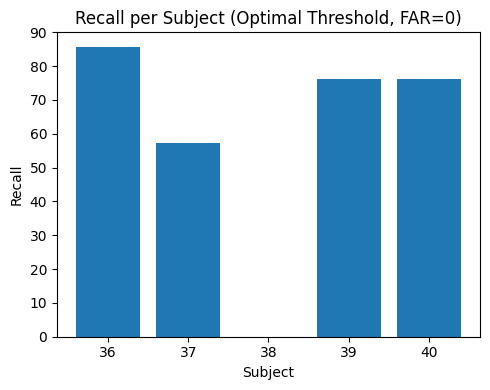

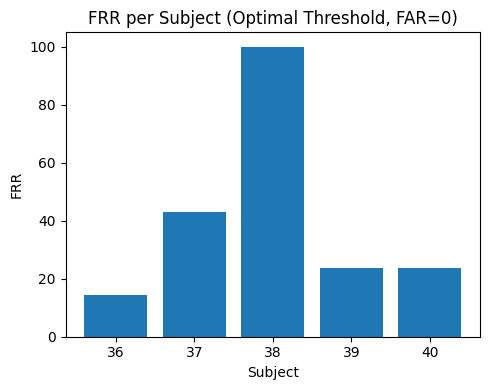

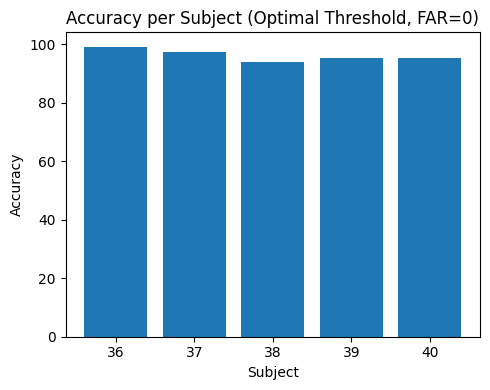

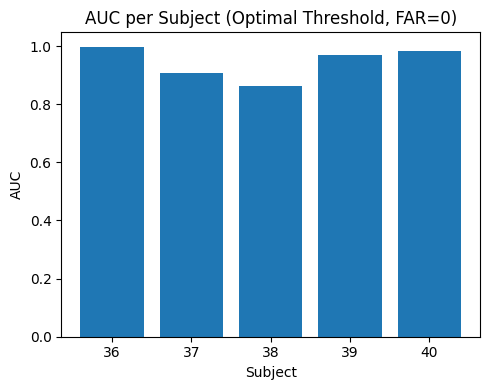

In [4]:
import matplotlib.pyplot as plt

# Make sure df_opt is defined from the previous cell

metrics_to_plot = ["Recall", "FRR", "Accuracy", "AUC"]

for metric in metrics_to_plot:
    plt.figure(figsize=(5, 4))
    plt.bar(df_opt.index.astype(str), df_opt[metric])
    plt.xlabel("Subject")
    plt.ylabel(metric)
    plt.title(f"{metric} per Subject (Optimal Threshold, FAR=0)")
    plt.tight_layout()
    plt.show()


In [5]:
df_opt

,best_thresh,TP,TN,FP,FN,FAR,FRR,Precision,Recall,Specificity,F1,Accuracy,AUC
subject,,,,,,,,,,,,,
36,0.04,6,105,0,1,0.0,14.285714,100.0,85.714286,100.0,92.307692,99.107143,0.997279
37,0.04,4,105,0,3,0.0,42.857143,100.0,57.142857,100.0,72.727273,97.321429,0.908163
38,0.24,0,105,0,7,0.0,100.000000,0.0,0.000000,100.0,0.000000,93.750000,0.861224
39,0.13,16,84,0,5,0.0,23.809524,100.0,76.190476,100.0,86.486486,95.238095,0.969104
40,0.09,16,84,0,5,0.0,23.809524,100.0,76.190476,100.0,86.486486,95.238095,0.983560
